In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

device = torch.device('cpu')

In [93]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
# tokenizer = BertTokenizer.from_pretrained('rubert_base_cased_sentence/')

C:\Users\Teamj\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Ber

In [94]:
df = pd.read_csv('task-3-dataset.csv')

In [95]:
df.head()

,отзывы,разметка
0,Оболочка после чистого андроида тоже очень нек...,-
1,"Нормальный телефон, очень красивая задняя панель",+
2,Деньги на ветер .,-
3,ну так себе,-
4,Ценник вполне адекватный для такой мощной нови...,+


In [96]:
df.replace({'+': 1, '-': 0}, inplace=True)

C:\Users\Teamj\AppData\Local\Temp\ipykernel_4888\3346452400.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'+': 1, '-': 0}, inplace=True)


In [97]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [98]:
train_df.columns

Index(['отзывы', 'разметка'], dtype='object')

In [99]:
train_text = train_df['отзывы'].astype('str')
train_labels = train_df['разметка']
test_text = test_df['отзывы'].astype('str')
test_labels = test_df['разметка']

In [100]:
train_df

,отзывы,разметка
150,"Для меня не хватает яркости, слишком большой",0
96,"он хорош! шустрый стильный, и что не мало важн...",1
200,"хорошая камера, долго держит зарядку, лучший т...",1
68,"Очень доволен телефоном, но телефон не для все...",1
156,"Тормозит даже в браузере, про игры вообще молч...",0
...,...,...
106,"Купил неделю назад в магазине, аккумулятора хв...",0
14,не очень быстрый,0
92,"Заказал айфон 15 pro,а вместо айфона получил ш...",0
179,"Самый мерзкий телефон из всего, что было за мн...",0


<Axes: >

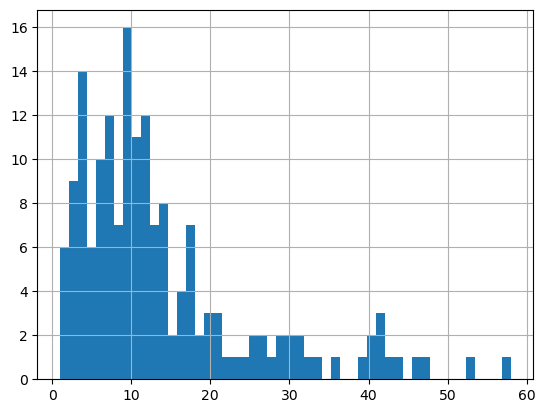

In [101]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

In [102]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 30,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = 30,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 8


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

In [103]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [104]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

C:\Users\Teamj\anaconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [108]:
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

# print(class_weights)
# # [0.8086199  1.31005794]

# weights = torch.tensor(class_weights, dtype = torch.float)
# # weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 20

In [109]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [110]:
train_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    # valid_loss, _ = evaluate()
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    # valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    # print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.35it/s]



Training loss: 0.698

 Epoch2 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.44it/s]



Training loss: 0.651

 Epoch3 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.30it/s]



Training loss: 0.584

 Epoch4 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.37it/s]



Training loss: 0.585

 Epoch5 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.02it/s]



Training loss: 0.555

 Epoch6 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.94it/s]



Training loss: 0.620

 Epoch7 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.44it/s]



Training loss: 0.485

 Epoch8 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.33it/s]



Training loss: 0.460

 Epoch9 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.29it/s]



Training loss: 0.449

 Epoch10 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.13it/s]



Training loss: 0.479

 Epoch11 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.50it/s]



Training loss: 0.481

 Epoch12 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.35it/s]



Training loss: 0.501

 Epoch13 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.36it/s]



Training loss: 0.462

 Epoch14 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.45it/s]



Training loss: 0.367

 Epoch15 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.52it/s]



Training loss: 0.482

 Epoch16 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.57it/s]



Training loss: 0.519

 Epoch17 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.55it/s]



Training loss: 0.412

 Epoch18 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.57it/s]



Training loss: 0.364

 Epoch19 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.50it/s]



Training loss: 0.378

 Epoch20 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.51it/s]


Training loss: 0.357


In [113]:
list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [114]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test_df['confidence'] = flat_preds

In [116]:
test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x>0.92 else 0)

print(classification_report(test_df['разметка'], test_df['pred']))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        14
           1       1.00      0.68      0.81        28

    accuracy                           0.79        42
   macro avg       0.80      0.84      0.78        42
weighted avg       0.87      0.79      0.79        42



In [117]:
test_df

,отзывы,разметка,confidence,pred
30,Позор какой-то честно говоря. Придется продавать.,0,0.836203,0
172,"Ну это Rapid Quantum Calculations, он мощный, ...",1,0.939871,1
84,"Лёгкий корпус, красивый пастельный цвет, внешн...",1,0.989457,1
199,"я очень довольна, функциональный, быстрый",1,0.993450,1
60,"Слабо ловит сигнал вай-вай, буквально на 8-10 ...",0,0.565634,0
155,"Пользуюсь примерно полгода, за это время не на...",1,0.579691,0
45,нет быстрой зарядки. лагает даже на рабочем ст...,0,0.896914,0
182,квантовый смартфон даже звучит круто,1,0.999746,1
9,"После QPhone Pro MAX отлично лежит в руке, бра...",1,0.999567,1
196,Для бюджетного телефона ничего более и не ожид...,1,0.949094,1
